### Introduction

**Batch normalization** is a popular method to fasten deep-network training process also solving the gradient vanishing or exploding problem. In [this post](https://kentchun33333.github.io/), I am going to first discuss some ideas, then take a glance on algorithms in the [paper](https://arxiv.org/pdf/1502.03167v3.pdf),and finally take a deep look on how tensorflow implementation it.


### 1. Brief concepts about normalization

It is quite common to use normalization in neural network, especially deep convnet. Before batch normalization layer, there are several ways/methods like as per-image-normalize, per-image whitening, per-batch normalization, per-batch whitening, local constrast normalization (LCN) and local response normalization (LRN). These methods are actually really good, and is sucessfully working in some conditions.

To me, the main core ideal is simple, that is ** only difference matters while delievering information**. Just think the information like electricity in cpu, nowadays the driving voltage is much lower than the past cpu, but it carried more heavy work, compute even faster and spend less energy. 

**We actually have multiple ways to normalize our data before or after any operation.** A good way or strategy to add the normalization is actually **depending on the operation before or after it.** For example, if you are going to applied a RELU with a threshod equal to 0.5 ( which is not common) and you would like to add a normalization-method before it. You probabily do not want to only add the normalization but also some shift like 0.1 or 0.3 to make sure this RELU-layer do not swipe too many information. For another example, you would like to introduce a **depth-wise or channel-wise normalization** after the conv-layer. Because, the conv-layer is actually a depth-wish operation. Depth in conv-operation is actually the numbers of filters/kernels which coressponding to a **( **filter-width \* filter-height \* previous-depth** )** of weights/neurals.

The batch normalization is basically following this concept but adding a trainable feature to it. **This feature makes it beautiful.**

For more informations about normalization, check this [post](http://yeephycho.github.io/2016/08/03/Normalizations-in-neural-networks/).

### 2. Expression in Math 

$ \begin{array} \\
\text{Algorithm 1 : Batch Normalizing Transform, applied to activation x over a mini-batch. } \\  
\hline 
\text{Input : Values of x over a mini-Batch : } B \{  x_{1 \text{ ... m }} \} \text{ ; Parameters to be learned : } \beta \text{ and } \gamma \\
\text{Output : A set of } Y : \{ y_{i} = \text{ BatchNorm}_{\beta, \gamma}(x^{i}) \} \\
\text{ } \mu_{ \beta } \leftarrow  \frac{1}{m} \sum_{i=1}^m (x_{i}) \text{ ----------------- mini-batch mean}\\
\text{ } \alpha^{2}_{ \beta } \leftarrow  \frac{1}{m} \sum_{i=1}^m (x_{i} - \mu_{\beta})^{2} \text{ --------- mini-batch variance}\\
\text{ } \hat{x}_{i} \leftarrow \frac{x_{i} - \mu_{\beta}}{\sqrt{\alpha^{2}_{\beta}+ \epsilon}} \text{ ---------------------- normalization where epsilon is the number to prevent dividing zero } \\
\text{ } y_{i} \leftarrow \gamma \hat{x}_{i} + \beta = \text{BN}_{\gamma, \beta}(x_{i}) \text{ -------- scale and shift}\\
\end{array} $


$ \begin{array} \\
\text{Algorithm 2 : Training a Batch-Normalized Network } \\  
\hline 
\text{Input : Network N with trainable parameters } \Theta \text{ ; subset of activations } \{ x^{(k)}\}^{K}_{k=1} \\
\text{Output : Batch-normalized network for inference, N}^{inf}_{\text{BN}} \\
\text{ 1: N}^{\text{tr}}_{\text{BN}} \leftarrow \text{ N ------ Training BN network} \\
\text{ 2: } \textbf{for } k = 1 ... K \textbf{  do } : \\ 
\text{ 3: Add transformation } y^{(k)} = \text{BN}_{\gamma^{(k)}, \beta^{(k)}}(x^{(k)}) \text{ to N}^{\text{tr}}_{\text{BN}} \text{ ( Alg. 1 )} \\ 
\text{ 4: Modify each layer in N}^{\text{tr}}_{\text{BN}} \text{ with input } x^{(k)} \text{ to take } y^{(k)} \text{ instead} \\
\text{ 5: } \textbf{end for }\\
\\
\text{ 6: Train N}^{\text{tr}}_{\text{BN}} \text{ to optimize the parameters } \Theta \cup \{ \gamma^{(k)}, \beta^{(k)} \}^{K}_{k=1}\\
\text{ 7: N}^{\text{inf}}_{\text{BN}} \leftarrow \text{N}^{\text{tr}}_{\text{BN}} text{ ---inference BN network with forzen parameters} \\
\\
\text{ 8: } \textbf{for } k = 1 ... K \textbf{  do } : \\ 
\text{ 9: //For clarity} x=x^{(k)}, \gamma = \gamma^{(k)}, \beta = \beta^{(k)} ... etc \\
\text{10: Process multiple training mini-batches B, each of size m, and average over them :}\\
\text{10: E}[x] \leftarrow \text{E}_{\beta}[\mu_{\beta}]\\
\text{10: Var}[x] \leftarrow \frac{m}{m-1} \text{E}_{\beta}[\alpha^{2}_{\beta}]\\
\text{11: In N}^{\text{inf}}_{\text{BN}} \text{, replace the transform } y = \text{BN}_{\gamma, \beta}(x) \text{ with } y = \frac{\gamma}{\sqrt{\text{Var}[x]+\epsilon}} \dot x + (\beta - \frac{\gamma \text{E}[x]}{\sqrt{\text{Var}[x]+\epsilon}})\\
\text{12: } \textbf{end for }\\
\end{array} $

### 3. How Tensorflow implements it ?
#### 3-1 Before dive into souce code : 

There are basically 4 main methods to compute derivatives or to say **backpropagation**.

- (1) Manually working out derivatives and coding the result

- (2) Numerical differentiation (using finite difference approximations)

- (3) **Symbolic differentiation** (expression manipulation in SW such as Max, Mathematica & Maple)

- (4) **Automatic differentiation** (Forward, Reversed & Optical Jocobian Accumulation)

And most of popular deep learning library had implemented either automatic reverse differenciation or symbolic differenciation while computing gradients and Hessian of an objective fuction  **Therefore, while implement the batch-normalization layer in real production, we just need to focus on the forward propagation. **

For more information about automatic differentiation, check this [paper](https://arxiv.org/pdf/1502.05767v2.pdf).

#### 3-2 Batch-normalization in Tensorflow.

In [4]:
import tensorflow as tf 

In [ ]:
def sufficient_statistics(x, axes, shift=None, keep_dims=False, name=None):
  """Calculate the sufficient statistics for the mean and variance of `x`.

  These sufficient statistics are computed using the one pass algorithm on
  an input that's optionally shifted. See:
  https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Computing_shifted_data

  Args:
    x: A `Tensor`.
    axes: Array of ints. Axes along which to compute mean and variance.
    shift: A `Tensor` containing the value by which to shift the data for
      numerical stability, or `None` if no shift is to be performed. A shift
      close to the true mean provides the most numerically stable results.
    keep_dims: produce statistics with the same dimensionality as the input.
    name: Name used to scope the operations that compute the sufficient stats.

  Returns:
    Four `Tensor` objects of the same type as `x`:

    * the count (number of elements to average over).
    * the (possibly shifted) sum of the elements in the array.
    * the (possibly shifted) sum of squares of the elements in the array.
    * the shift by which the mean must be corrected or None if `shift` is None.
  """
  axes = list(set(axes))
  with ops.name_scope(name, "sufficient_statistics", [x, shift]):
    x = ops.convert_to_tensor(x, name="x")
    x_shape = x.get_shape()
    if x_shape.is_fully_defined():
      counts = 1
      for d in axes:
        counts *= x_shape[d].value
      counts = constant_op.constant(counts, dtype=x.dtype)
    else:  # shape needs to be inferred at runtime.
      x_dims = array_ops.gather(array_ops.shape(x), axes)
      counts = math_ops.cast(
          math_ops.reduce_prod(x_dims), x.dtype, name="count")
    if shift is not None:
      shift = ops.convert_to_tensor(shift, name="shift")
      m_ss = math_ops.sub(x, shift)
      v_ss = math_ops.squared_difference(x, shift)
    else:  # no shift.
      m_ss = x
      v_ss = math_ops.square(x)
    m_ss = math_ops.reduce_sum(m_ss, axes, keep_dims=keep_dims, name="mean_ss")
    v_ss = math_ops.reduce_sum(v_ss, axes, keep_dims=keep_dims, name="var_ss")
  return counts, m_ss, v_ss, shift


def normalize_moments(counts, mean_ss, variance_ss, shift, name=None):
  """Calculate the mean and variance of based on the sufficient statistics.

  Args:
    counts: A `Tensor` containing a the total count of the data (one value).
    mean_ss: A `Tensor` containing the mean sufficient statistics: the (possibly
      shifted) sum of the elements to average over.
    variance_ss: A `Tensor` containing the variance sufficient statistics: the
      (possibly shifted) squared sum of the data to compute the variance over.
    shift: A `Tensor` containing the value by which the data is shifted for
      numerical stability, or `None` if no shift was performed.
    name: Name used to scope the operations that compute the moments.

  Returns:
    Two `Tensor` objects: `mean` and `variance`.
  """
  with ops.name_scope(name, "normalize", [counts, mean_ss, variance_ss, shift]):
    divisor = math_ops.reciprocal(counts, name="divisor")
    if shift is not None:
      shifted_mean = math_ops.mul(mean_ss, divisor, name="shifted_mean")
      mean = math_ops.add(shifted_mean, shift, name="mean")
    else:  # no shift.
      shifted_mean = math_ops.mul(mean_ss, divisor, name="mean")
      mean = shifted_mean
    variance = math_ops.sub(math_ops.mul(variance_ss, divisor),
                            math_ops.square(shifted_mean),
                            name="variance")
  return (mean, variance)


def moments(x, axes, shift=None, name=None, keep_dims=False):
  """Calculate the mean and variance of `x`.

  The mean and variance are calculated by aggregating the contents of `x`
  across `axes`.  If `x` is 1-D and `axes = [0]` this is just the mean
  and variance of a vector.

  When using these moments for batch normalization (see
  `tf.nn.batch_normalization`):

   * for so-called "global normalization", used with convolutional filters with
     shape `[batch, height, width, depth]`, pass `axes=[0, 1, 2]`.
   * for simple batch normalization pass `axes=[0]` (batch only).

  Args:
    x: A `Tensor`.
    axes: Array of ints.  Axes along which to compute mean and
      variance.
    shift: A `Tensor` containing the value by which to shift the data for
      numerical stability, or `None` if no shift is to be performed. A shift
      close to the true mean provides the most numerically stable results.
    name: Name used to scope the operations that compute the moments.
    keep_dims: produce moments with the same dimensionality as the input.

  Returns:
    Two `Tensor` objects: `mean` and `variance`.
  """
  with ops.name_scope(name, "moments", [x, axes, shift]):
    # The dynamic range of fp16 is too limited to support the collection of
    # sufficient statistics. As a workaround we simply perform the operations
    # on 32-bit floats before converting the mean and variance back to fp16
    y = math_ops.cast(x, dtypes.float32) if x.dtype == dtypes.float16 else x
    shift = math_ops.cast(shift, dtypes.float32) if (
        shift is not None and x.dtype == dtypes.float16) else shift
    counts, m_ss, v_ss, shift = sufficient_statistics(
        y, axes, shift=shift, keep_dims=keep_dims, name=name)
    with ops.control_dependencies([counts, m_ss, v_ss]):
      mean, variance = normalize_moments(counts, m_ss, v_ss, shift, name=name)
      if x.dtype == dtypes.float16:
        return (math_ops.cast(mean, dtypes.float16),
                math_ops.cast(variance, dtypes.float16))
      else:
        return (mean, variance)



Notice that in Batch-Normalization we are going to sent axes = [0,1,2] to **tf.nn.moment()** which is actually affecting the **tf.nn.sufficient_statistics()**, which is corresponding to [batch, height, width]. 

What sufficient_sta

4D tensor [batch, height, width, channel] => 2D tensor [ batch \* height \* width, channel ]


```python 
def sufficient_statistics(x, axes, shift=None, keep_dims=False, name=None):
    ...
    ...
      for d in axes:
        counts *= x_shape[d].value
      counts = constant_op.constant(counts, dtype=x.dtype)


In [22]:
import tensorflow as tf 
import cv2
from skimage.io import imread, imshow, imsave
from keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (50000, 32, 32, 3))
(50000, 'train samples')
(10000, 'test samples')


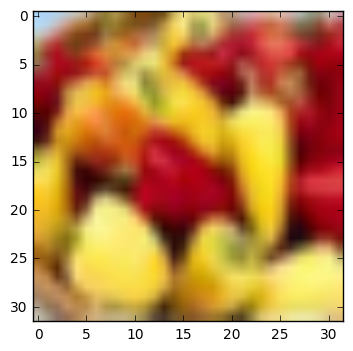

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline  
# pip install -U --force-reinstall matplotlib

plt.imshow(X_train[311])
plt.show()

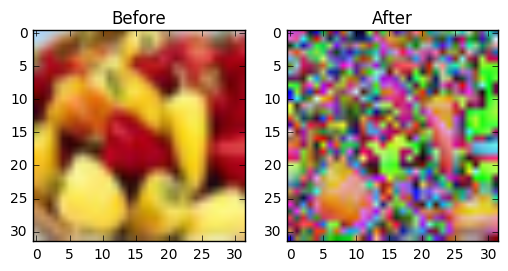

In [28]:
# normalize with numpy
import numpy as np

epslion = 1e-10
def operations(img):
    mean = int(np.mean(img))
    img -= mean
    std = np.std(img)
    return img / (std+epslion)

img = operations(X_train[311].copy())

fig = plt.figure()
a=fig.add_subplot(1,2,1)

imgplot = plt.imshow(X_train[311])
a.set_title('Before')

a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(img)
imgplot.set_clim(0.0,0.7)
a.set_title('After')

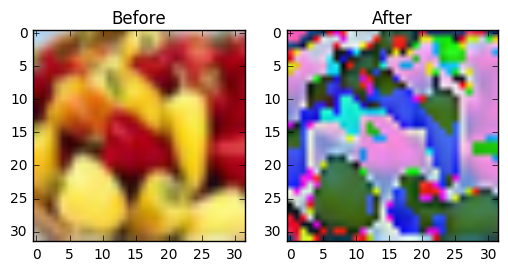

In [27]:
def operations(img):
    
    for i in range(3):
        img[:,:,i]-= int(np.mean(img[:,:,i]))
        #img[:,:,i] = img[:,:,i]/(np.std(img[:,:,i])+epslion)
    return img 

img = operations(X_train[311].copy())

fig = plt.figure()
a=fig.add_subplot(1,2,1)

imgplot = plt.imshow(X_train[311])
a.set_title('Before')

a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(img)
imgplot.set_clim(0.0,0.7)
a.set_title('After')




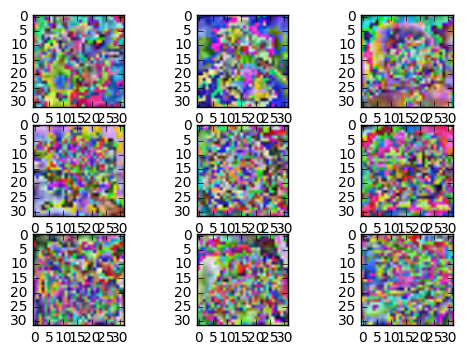

In [38]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


datagen.fit(X_train[310:330])
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i])
	# show the plot
	pyplot.show()
	break

Transfer Learning 

- https://github.com/ry/tensorflow-vgg16


# Reference 

- http://yeephycho.github.io/2016/08/03/Normalizations-in-neural-networks/

- https://github.com/pkmital/CADL/blob/master/session-4/libs/batch_norm.py

- http://cthorey.github.io./backpropagation/

- http://r2rt.com/implementing-batch-normalization-in-tensorflow.html

- https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

- https://www.zhihu.com/question/38102762

- http://shuokay.com/2016/10/15/wavenet/

- http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html

- http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow

In [3]:
import numpy as np
import tensorflow as tf
#from tensorflow.python import control_flow_ops

def batch_norm(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        # init beta
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        # init gamma
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [15]:
# Batch Normalization Forward

# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [16]:
# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)

# Note that pre-batch normalization bias is ommitted. The effect of this bias would be
# eliminated when subtracting the batch mean. Instead, the role of the bias is performed
# by the new beta variable. See Section 3.2 of the BN2015 paper.
z1_BN = tf.matmul(x,w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# Create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

In [17]:
# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

In [18]:
# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

In [24]:
'''
Save and Restore a model using TensorFlow.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf

# Parameters
learning_rate = 0.001
batch_size = 100
display_step = 1
model_path = "/tmp/model.ckpt"

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# Running first session
print("Starting 1st session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Training cycle
    for epoch in range(3):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("First Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)

# Running a new session
print("Starting 2nd session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % save_path)

    # Resume training
    for epoch in range(7):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Second Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval(
        {x: mnist.test.images, y: mnist.test.labels}))

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Starting 1st session...
Epoch: 0001 cost= 164.709009379
Epoch: 0002 cost= 39.746273469
Epoch: 0003 cost= 24.618006897
First Optimization Finished!
Accuracy: 0.9129
Model saved in file: /tmp/model.ckpt
Starting 2nd session...
Model restored from file: /tmp/model.ckpt
Epoch: 0001 cost= 17.003537263
Epoch: 0002 cost= 12.180232949
Epoch: 0003 cost= 9.019476439
Epoch: 0004 cost= 6.707634071
Epoch: 0005 cost= 5.014267356
Epoch: 0006 cost= 3.689016492
Epoch: 0007 cost= 2.808352564
Second Optimization Finished!
Accuracy: 0.94


In [8]:

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, 20, 20, 10], name='input')
phase_train = tf.placeholder(tf.bool, name='phase_train')

# generate random noise to pass into batch norm
x_gen = tf.random_normal([50,20,20,10])
pt_false = tf.Variable(tf.constant(True))

#generate a constant variable to pass into batch norm
y = x_gen.eval()

[bn, bn_vars] = batch_norm(x, 10, phase_train)

tf.initialize_all_variables().run()
train_step = lambda: bn.eval({x:x_gen.eval(), phase_train:True})
test_step = lambda: bn.eval({x:y, phase_train:False})
test_step_c = lambda: bn.eval({x:y, phase_train:True})

# Verify that this is different as expected, two different x's have different norms
print(train_step()[0][0][0])
print(train_step()[0][0][0])

# Verify that this is same as expected, same x's (y) have same norm
print(train_step_c()[0][0][0])
print(train_step_c()[0][0][0])

# THIS IS DIFFERENT but should be they same, should only be reading from the ema.
print(test_step()[0][0][0])
print(test_step()[0][0][0])

TypeError: 'Output' object is not iterable.

In [5]:
import math

n_in, n_out = 3, 16
ksize = 3
stride = 1
phase_train = tf.placeholder(tf.bool, name='phase_train')
input_image = tf.placeholder(tf.float32, name='input_image')
kernel = tf.Variable(tf.truncated_normal([ksize, ksize, n_in, n_out],
                                   stddev=math.sqrt(2.0/(ksize*ksize*n_out))),
                                   name='kernel')
conv = tf.nn.conv2d(input_image, kernel, [1,stride,stride,1], padding='SAME')
conv_bn = batch_norm(conv, n_out, phase_train)
relu = tf.nn.relu(conv_bn)

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    for i in range(20):
        test_image = np.random.rand(4,32,32,3)
        sess_outputs = session.run([relu],
          {input_image.name: test_image, phase_train.name: True})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [3]:
from keras.engine import Layer, InputSpec
from keras import initializations, regularizers
from keras import backend as K


class BatchNormalization(Layer):
    '''Normalize the activations of the previous layer at each batch,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        epsilon: small float > 0. Fuzz parameter.
        mode: integer, 0, 1 or 2.
            - 0: feature-wise normalization.
                Each feature map in the input will
                be normalized separately. The axis on which
                to normalize is specified by the `axis` argument.
                Note that if the input is a 4D image tensor
                using Theano conventions (samples, channels, rows, cols)
                then you should set `axis` to `1` to normalize along
                the channels axis.
                During training we use per-batch statistics to normalize
                the data, and during testing we use running averages
                computed during the training phase.
            - 1: sample-wise normalization. This mode assumes a 2D input.
            - 2: feature-wise normalization, like mode 0, but
                using per-batch statistics to normalize the data during both
                testing and training.
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
            Note that the order of this list is [gamma, beta, mean, std]
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the gamma vector.
        beta_regularizer: instance of [WeightRegularizer](../regularizers.md),
            applied to the beta vector.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://jmlr.org/proceedings/papers/v37/ioffe15.pdf)
    '''
    def __init__(self, epsilon=1e-5, mode=0, axis=-1, momentum=0.99,
                 weights=None, beta_init='zero', gamma_init='one',
                 gamma_regularizer=None, beta_regularizer=None, **kwargs):
        self.supports_masking = True
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.epsilon = epsilon
        self.mode = mode
        self.axis = axis
        self.momentum = momentum
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.initial_weights = weights
        if self.mode == 0:
            self.uses_learning_phase = True
        super(BatchNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)

        self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        self.regularizers = []
        if self.gamma_regularizer:
            self.gamma_regularizer.set_param(self.gamma)
            self.regularizers.append(self.gamma_regularizer)

        if self.beta_regularizer:
            self.beta_regularizer.set_param(self.beta)
            self.regularizers.append(self.beta_regularizer)

        self.running_mean = K.zeros(shape,
                                    name='{}_running_mean'.format(self.name))
        self.running_std = K.ones(shape,
                                  name='{}_running_std'.format(self.name))
        self.non_trainable_weights = [self.running_mean, self.running_std]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        self.called_with = None

    def call(self, x, mask=None):
        if self.mode == 0 or self.mode == 2:
            assert self.built, 'Layer must be built before being called'
            input_shape = self.input_spec[0].shape

            reduction_axes = list(range(len(input_shape)))
            del reduction_axes[self.axis]
            broadcast_shape = [1] * len(input_shape)
            broadcast_shape[self.axis] = input_shape[self.axis]

            if self.mode == 2:
                x_normed, mean, std = K.normalize_batch_in_training(
                    x, self.gamma, self.beta, reduction_axes,
                    epsilon=self.epsilon)
            else:
                # mode 0
                if self.called_with not in {None, x}:
                    raise Exception('You are attempting to share a '
                                    'same `BatchNormalization` layer across '
                                    'different data flows. '
                                    'This is not possible. '
                                    'You should use `mode=2` in '
                                    '`BatchNormalization`, which has '
                                    'a similar behavior but is shareable '
                                    '(see docs for a description of '
                                    'the behavior).')
                self.called_with = x
                x_normed, mean, std = K.normalize_batch_in_training(
                    x, self.gamma, self.beta, reduction_axes,
                    epsilon=self.epsilon)

                self.updates = [K.moving_average_update(self.running_mean, mean, self.momentum),
                                K.moving_average_update(self.running_std, std, self.momentum)]

                if K.backend() == 'tensorflow' and sorted(reduction_axes) == range(K.ndim(x))[:-1]:
                    x_normed_running = K.batch_normalization(
                        x, self.running_mean, self.running_std,
                        self.beta, self.gamma,
                        epsilon=self.epsilon)
                else:
                    # need broadcasting
                    broadcast_running_mean = K.reshape(self.running_mean, broadcast_shape)
                    broadcast_running_std = K.reshape(self.running_std, broadcast_shape)
                    broadcast_beta = K.reshape(self.beta, broadcast_shape)
                    broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
                    x_normed_running = K.batch_normalization(
                        x, broadcast_running_mean, broadcast_running_std,
                        broadcast_beta, broadcast_gamma,
                        epsilon=self.epsilon)

                # pick the normalized form of x corresponding to the training phase
                x_normed = K.in_train_phase(x_normed, x_normed_running)

        elif self.mode == 1:
            # sample-wise normalization
            m = K.mean(x, axis=-1, keepdims=True)
            std = K.sqrt(K.var(x, axis=-1, keepdims=True) + self.epsilon)
            x_normed = (x - m) / (std + self.epsilon)
            x_normed = self.gamma * x_normed + self.beta
        return x_normed

    def get_config(self):
        config = {'epsilon': self.epsilon,
                  'mode': self.mode,
                  'axis': self.axis,
                  'gamma_regularizer': self.gamma_regularizer.get_config() if self.gamma_regularizer else None,
                  'beta_regularizer': self.beta_regularizer.get_config() if self.beta_regularizer else None,
                  'momentum': self.momentum}
        base_config = super(BatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [6]:
from IPython.core.display import HTML
HTML("""<style>
div.text_cell_render h1 {font-size: 2.4em;line-height:2.6em;text-align:left;}
div.text_cell_render h3 {font-size: 1.8em;line-height:2.0em;text-align:left;}
div.text_cell_render h4 {font-size: 1.6em;line-height:1.8em;text-align:left;}
div.text_cell_render p {font-size: 1.4em;line-height:1.4em;text-align:left;}
div.text_cell_render li {font-size: 1.0em;line-height:1.2em;text-align:left;}
div.container pre{font-family: Monaco;font-size: 1.2em;line-height:1.em;}
</style>""")

- [CS231 Youtube](https://www.youtube.com/watch?v=Vf_-OkqbwPo&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&index=12)

- 

In [41]:
import numpy as np

x = np.random.random(size=(10,30,30,3))
print (x.shape)

tf_x = tf.placeholder("float", [None, 30,30,3])

input1 = tf.placeholder(tf.float32) # place holder is not able to be eval
input2 = tf.Variable(x)
#output = tf.mul(input1, input2)


with tf.Session() as sess:
    
    sess.run(tf.initialize_all_variables())
    
    print (input2.eval())
    
    # Show in list or np array 
    x_ = sess.run([tf_x], feed_dict = { tf_x:x })
    print (x_ )


(10, 30, 30, 3)
[[[[ 0.89832491  0.74073259  0.69702154]
   [ 0.41813199  0.30042932  0.55091663]
   [ 0.17186376  0.71949197  0.75365476]
   ..., 
   [ 0.81863702  0.56082664  0.7038035 ]
   [ 0.40530724  0.94762405  0.66999269]
   [ 0.12545994  0.70678033  0.86147227]]

  [[ 0.47938645  0.66544564  0.02400668]
   [ 0.00351703  0.43009897  0.35642966]
   [ 0.87072869  0.64561302  0.33936732]
   ..., 
   [ 0.13518703  0.75539665  0.66291676]
   [ 0.24880344  0.7110323   0.20449154]
   [ 0.01424011  0.55126724  0.62524347]]

  [[ 0.24424882  0.45313095  0.58476978]
   [ 0.86441355  0.46237933  0.85738481]
   [ 0.70850982  0.87347843  0.68618125]
   ..., 
   [ 0.44556057  0.2104693   0.28916441]
   [ 0.61423935  0.39506338  0.10325649]
   [ 0.05635458  0.8378674   0.85790131]]

  ..., 
  [[ 0.35559305  0.2532878   0.23764048]
   [ 0.42841687  0.13936585  0.89868522]
   [ 0.78594937  0.38990995  0.67079933]
   ..., 
   [ 0.53712862  0.43112461  0.44864514]
   [ 0.08828806  0.92606751  0.2

# 核心思維

因為差異所以存在。
Pr( Difference | Operation )

訊息的傳遞的編碼與解碼, 只要訊號存在差異，就可以分辨。因此大小的量度，意義不大。或說，大小的定義，也是藉由一些測量/交互/操作，所得到具有**差異**的信息。

因此只要操作相互獨立，數據保持差異，則訊息無損。
數據的量度是透過其相依的測量/交互/操作所得到的。

道可道，非常道。但我們可以舉一些例子：

CPU的驅動電壓，從早期到現在基本上小了很多，但是這和處理的信息量其實是毫無相關的。

現在的ＣＰＵ並不因位驅動電壓減小了，而使得處理的信息量變小。

同理，我們腦中的神經元，處理的信息，其電壓更是微小。

數據對於類神經網路，其實就相當於電壓或是電流變化相當於真正的神經元一樣。

基本上，只要我們可以保持差異，那信息就不會丟失，只是對於物理量度來說，可能跨越不夠某些反應/交戶/操作，所需要的活化能，這其實是另一個量度世界的考量了。

作者採用了標準化，保持相對差異。

而保持差異因為存在，其實是依據(操作/交互/反應/量測)而定的。因為每一次(操作/交互/反應/量測)，就會產生新的量度。


所以BN使用的方法時機，會根據操作不同 (conv 操作與 fully connect 操作)


